# Privacy Policy Clustering Analysis
This notebook demonstrates the complete machine learning pipeline from clustering privcy policies using graph transformed yml files. It includes data transformation, exploratory data analysis (EDA), clustering and evaluation.

# Imports and Setup

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
import seaborn as sns
import yaml
import os
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
import umap
from sklearn.manifold import TSNE
import plotly.express as px
from scipy.sparse import hstack
import numpy as np

##  Data Transformation

In [14]:
def transform_graphs():
    """
    Transforms privacy policy knowledge graphs from YAML files into a structured CSV format.

    This function scans the local 'graphfiles/' directory for .yml files, extracts structured
    information (such as source, target, relation type, purposes, and example texts) from each graph,
    and compiles the results into a single CSV file named 'privacy_policy_data.csv'.

    Each entry in the output CSV represents a data collection or processing relationship within a
    privacy policy, suitable for downstream analysis like clustering or visualization.

    The expected structure inside each YAML file includes:
        - 'links': a list of dictionaries with keys like 'source', 'target', 'key', 'text', and 'purposes'.

    Raises:
        FileNotFoundError: If the 'graphfiles/' directory does not exist.

    Output:
        A CSV file named 'privacy_policy_data.csv' saved to the working directory.
    """

    import os
    import yaml
    import pandas as pd

    def extract_graph_data(filepath, app_name):
        with open(filepath, 'r') as f:
            graph = yaml.safe_load(f)
        data = []
        for link in graph.get("links", []):
            source = link.get("source", "")
            target = link.get("target", "")
            relation = link.get("key", "")
            texts = link.get("text", [])
            purpose_dict = link.get("purposes", {})
            categories = [k for k, v in purpose_dict.items() if v]
            category_str = ', '.join(categories) if categories else 'unspecified'
            purpose_list = [p for p_group in purpose_dict.values() for p in p_group] if purpose_dict else ["unspecified"]
            purpose_str = ', '.join(purpose_list)
            for text in texts:
                data.append({
                    "App": app_name,
                    "Source": source,
                    "Relation": relation,
                    "Target": target,
                    "Example Text": text,
                    "Purpose Categories": category_str,
                    "Purpose Details": purpose_str
                })
        return data

    # Updated to look inside 'graph files/' folder
    folder_path = "./graph files"  # relative path
    # Validate folder exists
    if not os.path.exists(folder_path):
        raise FileNotFoundError(f"Folder '{folder_path}' not found. Make sure it's in the same directory as this notebook.")

    file_paths = {
        os.path.splitext(f)[0]: os.path.join(folder_path, f)
        for f in os.listdir(folder_path)
        if f.endswith(".yml")
    }

    combined_data = []
    for app_name, filename in file_paths.items():
        combined_data.extend(extract_graph_data(filename, app_name))

    df = pd.DataFrame(combined_data)
    df.to_csv("privacy_policy_data.csv", index=False)
    print(" Saved as privacy_policy_data.csv")



##  Exploratory Data Analysis (EDA)

In [15]:

def perform_eda():
    """
    Performs exploratory data analysis (EDA) on the privacy policy dataset.

    This function reads the generated 'privacy_policy_data.csv' file, analyzes
    the distribution of key columns such as 'Relation', 'Purpose Categories', and 'Source',
    and visualizes their frequencies using bar plots. It helps identify common data types
    and relation patterns across different apps' privacy policies.

    Assumes that 'privacy_policy_data.csv' has already been created by `transform_graphs()`.

    Output:
        Displays summary bar charts for:
        - Purpose Categories distribution
        - Relation types
        - Top 10 most common Sources
        - Top 10 most common Targets
    """


    df = pd.read_csv('privacy_policy_data.csv')
    print(df.head())

    plt.figure(figsize=(10, 6))
    df['Relation'].value_counts().plot(kind='barh', color='skyblue')
    plt.title("Distribution of Relationship Types")
    plt.xlabel("Count")
    plt.tight_layout()
    plt.show()

    top_targets = df['Target'].value_counts().head(10)
    plt.figure(figsize=(10, 6))
    top_targets.plot(kind='barh', color='lightgreen')
    plt.title("Top 10 Most Collected Data Types")
    plt.xlabel("Count")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 8))
    purpose_counts = df['Purpose Categories'].str.split(', ').explode().value_counts()
    purpose_counts.plot.pie(autopct='%1.1f%%', startangle=140)
    plt.title("Distribution of Data Use Purposes")
    plt.ylabel("")
    plt.tight_layout()
    plt.show()

    text_blob = ' '.join(df['Example Text'].dropna())
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_blob)
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title("Word Cloud of Example Policy Text")
    plt.tight_layout()
    plt.show()


## Clustering

In [16]:
def perform_clustering(k=3, sample_size=None, svd_dim=50, tsne_dim=2, umap_dim=2):

    """
    Performs clustering on privacy policy data using K-Means and visualizes results via dimensionality reduction.

    This function:
    - Loads the 'privacy_policy_data.csv' dataset.
    - Vectorizes the 'Target' column using TF-IDF and encodes other columns using OneHotEncoder.
    - Combines all features and applies K-Means clustering (with a user-defined k).
    - Visualizes clustering results using SVD, t-SNE, and UMAP.
    - Shows the elbow plot to help choose optimal k.
    - Prints top TF-IDF keywords and metadata per cluster.

    Args:
        k (int): Number of clusters for K-Means (default is 3).
        sample_size (int, optional): If set, samples the dataset to this number of rows.
        svd_dim (int): Number of dimensions to retain before t-SNE/UMAP (default 50).
        tsne_dim (int): Number of output dimensions for t-SNE (default 2).
        umap_dim (int): Number of output dimensions for UMAP (default 2).

    Returns:
        dict: A dictionary containing:
            - 'df_clean': The cleaned and clustered DataFrame.
            - 'combined_features': The vectorized feature matrix.
            - 'clusters': Cluster labels from K-Means.
            - 'svd': 2D coordinates from SVD.
            - 'tsne': 2D coordinates from t-SNE.
            - 'umap': 2D coordinates from UMAP.
    """

    # Load data
    df = pd.read_csv("privacy_policy_data.csv")
    df_clean = df[['Target', 'Purpose Categories', 'Relation', 'Source']].dropna()
    df_clean['Target'] = df_clean['Target'].str.replace(' ', '_')

    # Optional subsampling
    if sample_size and sample_size < len(df_clean):
        df_clean = df_clean.sample(sample_size, random_state=42).reset_index(drop=True)

    # Vectorization
    tfidf = TfidfVectorizer()
    tfidf_matrix = tfidf.fit_transform(df_clean['Target'])
    encoder = OneHotEncoder(sparse_output=False)
    encoded_other = encoder.fit_transform(df_clean[['Purpose Categories', 'Relation', 'Source']])
    combined_features = hstack([tfidf_matrix, encoded_other])

    # K-Means clustering
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(combined_features)
    df_clean['Cluster'] = clusters
    num_clusters = len(np.unique(clusters))
    cluster_cmap = cm.get_cmap('rainbow', num_clusters)

    # SVD Visualization
    svd_vis = TruncatedSVD(n_components=2, random_state=42)
    reduced_vis = svd_vis.fit_transform(combined_features)
    plt.figure(figsize=(8, 6))
    plt.scatter(reduced_vis[:, 0], reduced_vis[:, 1], c=clusters, cmap=cluster_cmap, alpha=0.7)
    for i in range(num_clusters):
        plt.scatter([], [], c=[cluster_cmap(i)], label=f'Cluster {i}')
    plt.title("SVD Clustering Visualization")
    plt.xlabel("SVD Component 1")
    plt.ylabel("SVD Component 2")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Elbow Method
    inertia = []
    k_values = list(range(1, 11))
    for i in k_values:
        km = KMeans(n_clusters=i, random_state=42)
        km.fit(combined_features)
        inertia.append(km.inertia_)
    plt.figure(figsize=(6, 4))
    plt.plot(k_values, inertia, marker='o')
    plt.title("Elbow Method for Optimal k")
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Inertia")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # SVD pre-reduction for t-SNE and UMAP
    svd_model = TruncatedSVD(n_components=svd_dim, random_state=42)
    reduced = svd_model.fit_transform(combined_features)

    # t-SNE Visualization
    tsne = TSNE(n_components=tsne_dim, random_state=42, perplexity=30)
    tsne_features = tsne.fit_transform(reduced)
    plt.figure(figsize=(8, 6))
    plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=clusters, cmap=cluster_cmap, alpha=0.7)
    for i in range(num_clusters):
        plt.scatter([], [], c=[cluster_cmap(i)], label=f'Cluster {i}')
    plt.title("t-SNE Clustering Visualization")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # UMAP Visualization
    umap_reducer = umap.UMAP(n_components=umap_dim, random_state=42)
    umap_features = umap_reducer.fit_transform(reduced)
    plt.figure(figsize=(8, 6))
    plt.scatter(umap_features[:, 0], umap_features[:, 1], c=clusters, cmap=cluster_cmap, alpha=0.7)
    for i in range(num_clusters):
        plt.scatter([], [], c=[cluster_cmap(i)], label=f'Cluster {i}')
    plt.title("UMAP Clustering Visualization")
    plt.xlabel("UMAP Component 1")
    plt.ylabel("UMAP Component 2")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Cluster Summary
    tfidf_feature_names = tfidf.get_feature_names_out()
    for cluster_id in sorted(df_clean['Cluster'].unique()):
        print(f"\n Cluster {cluster_id}:")
        indices = df_clean[df_clean['Cluster'] == cluster_id].index
        cluster_tfidf = tfidf_matrix[indices].mean(axis=0).A1
        top_indices = cluster_tfidf.argsort()[::-1][:5]
        top_keywords = [tfidf_feature_names[i] for i in top_indices]
        print("  Top Keywords (Target):", top_keywords)
        print("  Top Purpose Category:", df_clean.loc[indices, 'Purpose Categories'].value_counts().idxmax())
        print("  Top Relation:", df_clean.loc[indices, 'Relation'].value_counts().idxmax())
        print("  Top Source:", df_clean.loc[indices, 'Source'].value_counts().idxmax())

    return {
        "df_clean": df_clean,
        "combined_features": combined_features,
        "clusters": clusters,
        "svd": reduced_vis,
        "tsne": tsne_features,
        "umap": umap_features
    }


In [17]:
def print_enhanced_cluster_summaries(df_clustered, df_with_parent):
    """
    Prints top targets and parent entity groupings per cluster to support interpretation.

    Args:
        df_clustered (DataFrame): The cleaned DataFrame with a 'Cluster' column.
        df_with_parent (DataFrame): A corresponding DataFrame that includes a 'Parent_Entity' column.
    """
    df_with_parent_aligned = df_with_parent.set_index(df_clustered.index)

    for cluster_id in sorted(df_clustered["Cluster"].dropna().unique()):
        print(f"\nCluster {int(cluster_id)} Summary:")
        cluster_df = df_clustered[df_clustered["Cluster"] == cluster_id]
        parent_df = df_with_parent_aligned.loc[cluster_df.index]

        top_targets = cluster_df["Target"].value_counts().head(5)
        print("  Top Targets:")
        for target, count in top_targets.items():
            print(f"    - {target} ({count})")

        if "Parent_Entity" in parent_df.columns:
            top_parents = parent_df["Parent_Entity"].dropna().value_counts().head(3)
            if not top_parents.empty:
                print("  Parent Entity Groupings (Hierarchy):")
                for parent, count in top_parents.items():
                    print(f"    - {parent} ({count})")
                print("  ⤷ These targets are subsumed under broader parent entities for semantic clarity.")

        for col in ["Purpose Categories", "Relation", "Source"]:
            if col in cluster_df.columns:
                top_value = cluster_df[col].mode()[0] if not cluster_df[col].mode().empty else "N/A"
                print(f"  Most Common {col}: {top_value}")


## Evaluation

In [18]:
from sklearn.metrics import silhouette_score
from sklearn.manifold import trustworthiness

def eval(results):
    """
    Evaluates the quality of clustering and dimensionality reduction.

    Given the output from `perform_clustering()`, this function computes:
    - Silhouette scores for each of the three embedding methods (SVD, t-SNE, UMAP),
      which indicate how well-separated the clusters are.
    - Trustworthiness scores to assess how well each dimensionality reduction
      technique preserves local neighborhood structure from the original feature space.

    Args:
        results (dict): The dictionary returned by `perform_clustering()`, containing:
            - 'combined_features': Original high-dimensional feature matrix.
            - 'clusters': Cluster labels assigned by K-Means.
            - 'svd', 'tsne', 'umap': 2D embedding coordinates for visualization.

    Output:
        Prints:
        - Silhouette scores for each embedding method.
        - Trustworthiness scores for each embedding method.
    """

    print("\n=== Evaluation Metrics ===")

    # Extract required components
    combined_features = results["combined_features"]
    clusters = results["clusters"]
    svd_vis = results["svd"]
    tsne_features = results["tsne"]
    umap_features = results["umap"]

    # Silhouette Scores
    try:
        svd_sil = silhouette_score(svd_vis, clusters)
        tsne_sil = silhouette_score(tsne_features, clusters)
        umap_sil = silhouette_score(umap_features, clusters)

        print("Silhouette Scores:")
        print(f"  SVD:   {svd_sil:.4f}")
        print(f"  t-SNE: {tsne_sil:.4f}")
        print(f"  UMAP:  {umap_sil:.4f}")
    except Exception as e:
        print("Silhouette Score error:", e)

    # Trustworthiness Scores
    try:
        svd_trust = trustworthiness(combined_features, svd_vis, n_neighbors=5)
        tsne_trust = trustworthiness(combined_features, tsne_features, n_neighbors=5)
        umap_trust = trustworthiness(combined_features, umap_features, n_neighbors=5)

        print("\nTrustworthiness Scores:")
        print(f"  SVD:   {svd_trust:.4f}")
        print(f"  t-SNE: {tsne_trust:.4f}")
        print(f"  UMAP:  {umap_trust:.4f}")
    except Exception as e:
        print("Trustworthiness Score error:", e)



##  Main Pipeline Execution

Step 1: Transforming Graph YAML Files...
 Saved as privacy_policy_data.csv

Step 2: Performing Exploratory Data Analysis (EDA)...
        App Source Relation            Target  \
0  Cerebral     we  COLLECT  UNSPECIFIED_DATA   
1  Cerebral     we  COLLECT  UNSPECIFIED_DATA   
2  Cerebral     we  COLLECT  UNSPECIFIED_DATA   
3  Cerebral     we  COLLECT  UNSPECIFIED_DATA   
4  Cerebral     we  COLLECT  UNSPECIFIED_DATA   

                                        Example Text Purpose Categories  \
0  Generally, we keep your information no longer ...              legal   
1  If we learn that we have received any informat...              legal   
2  Note: if you choose to allow other apps on you...              legal   
3  The length of time for which we retain informa...              legal   
4  We may also disclose your information in dilig...              legal   

                                     Purpose Details  
0  to comply with our legal obligations, as neces...  
1  to comply w

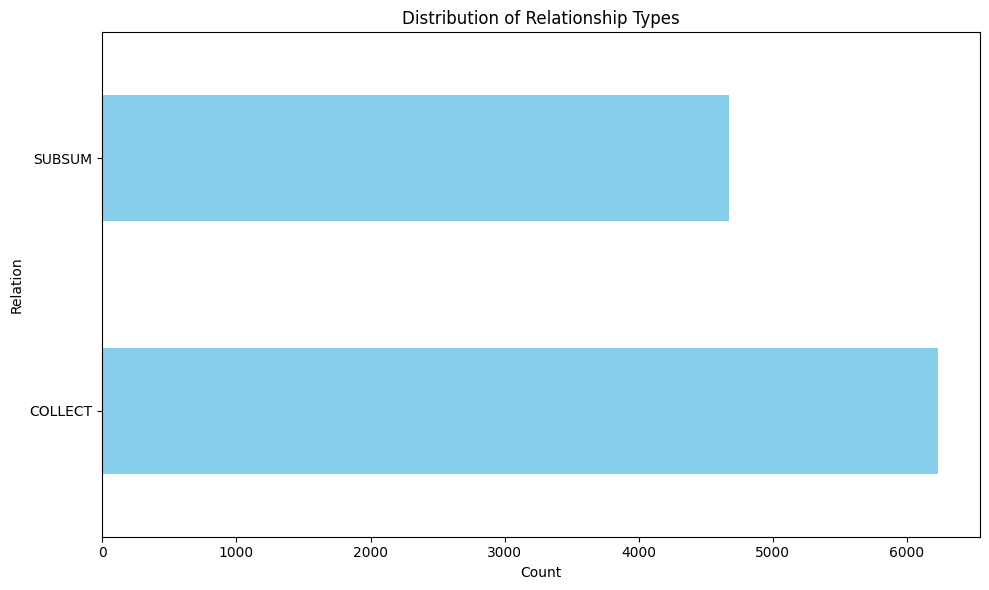

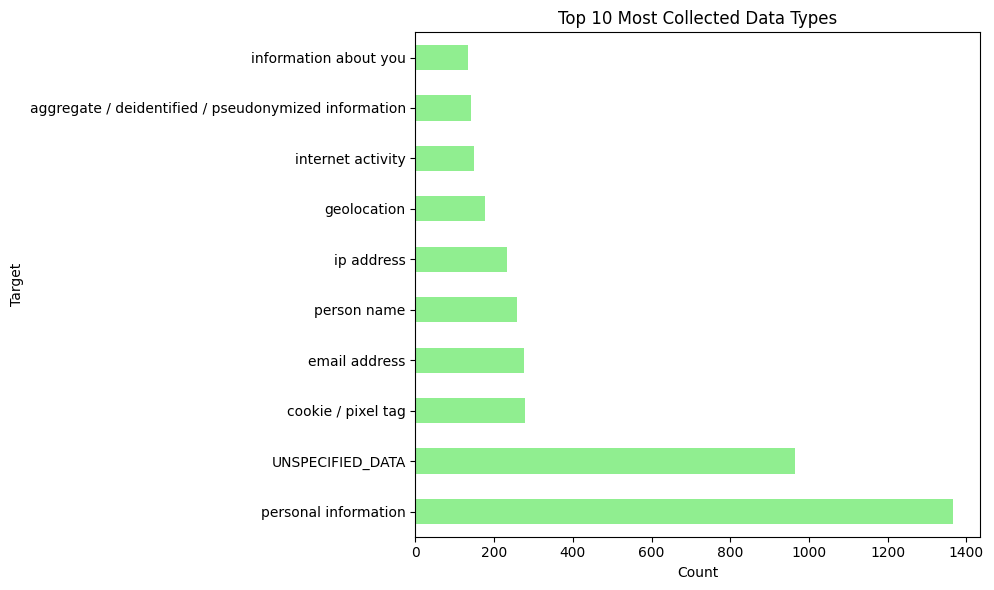

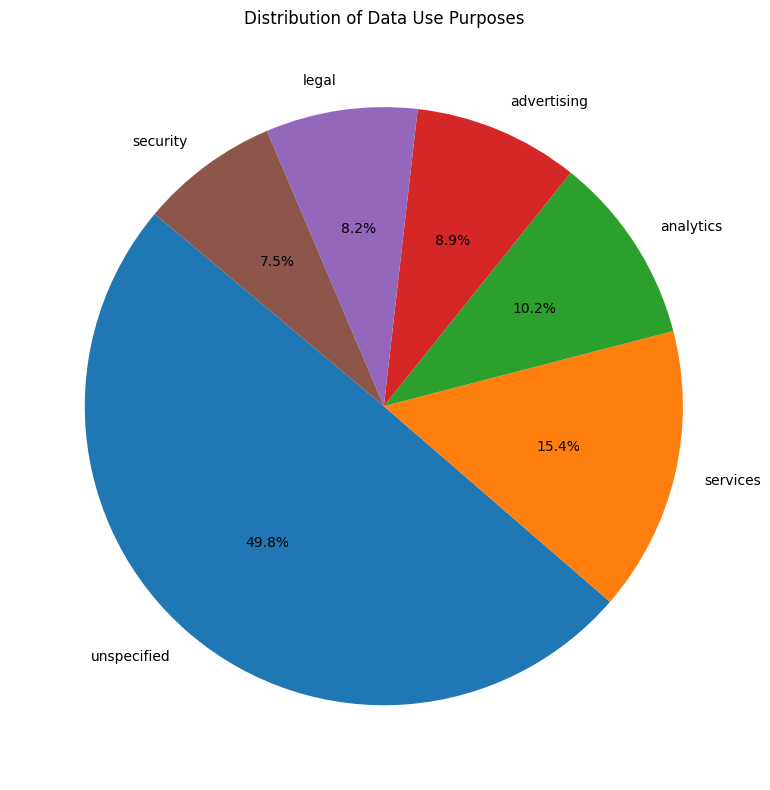

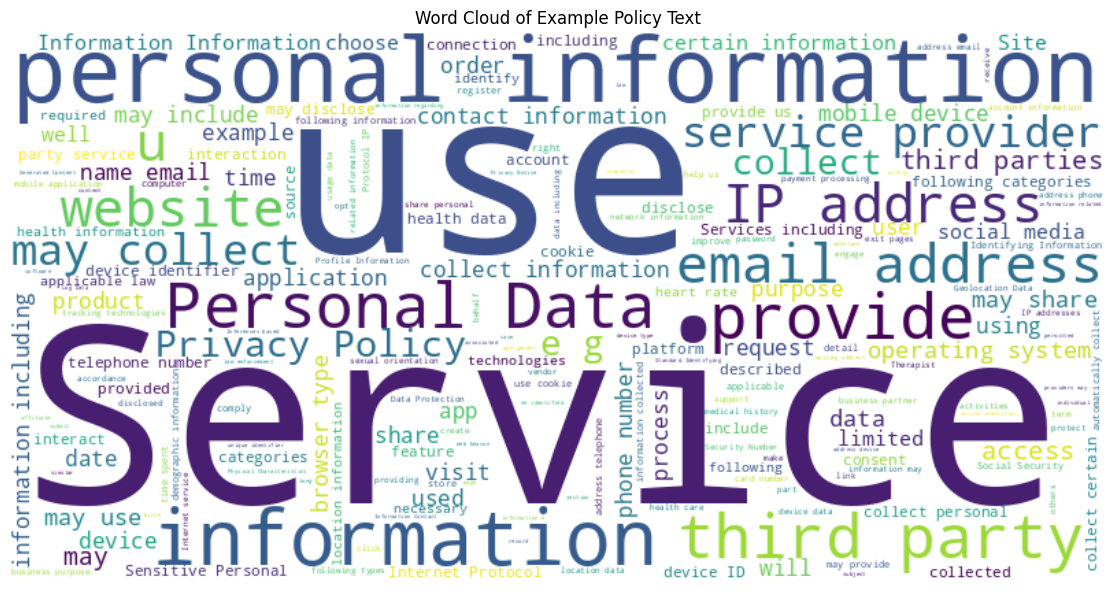


 Step 3: Clustering and Evaluation...


<ipython-input-16-dc658c2e5e26>:52: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cluster_cmap = cm.get_cmap('rainbow', num_clusters)


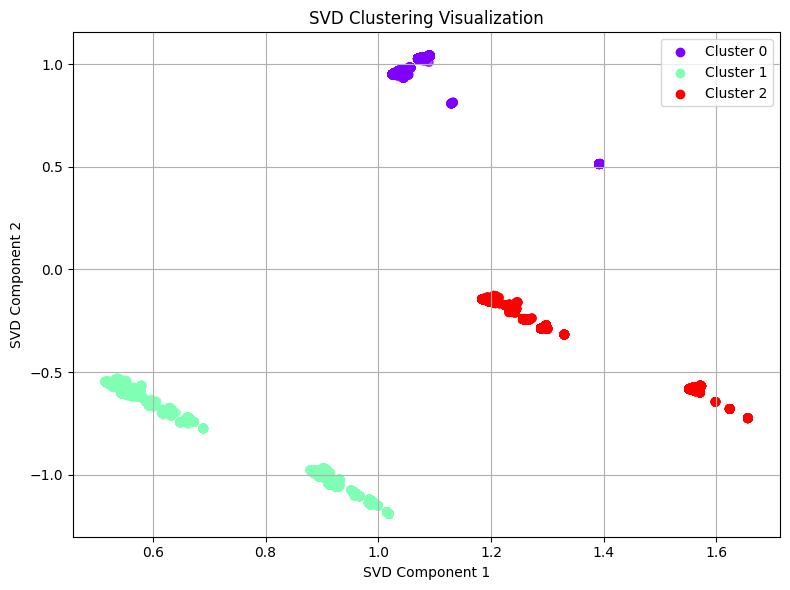

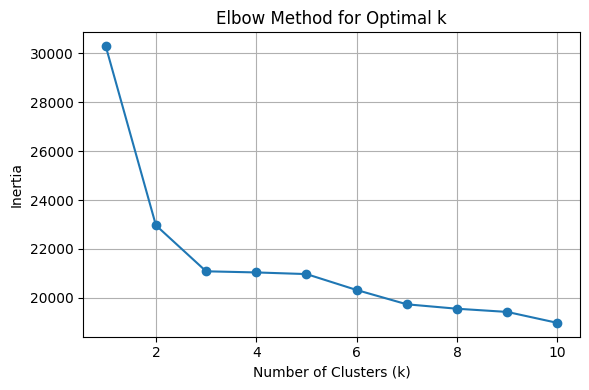

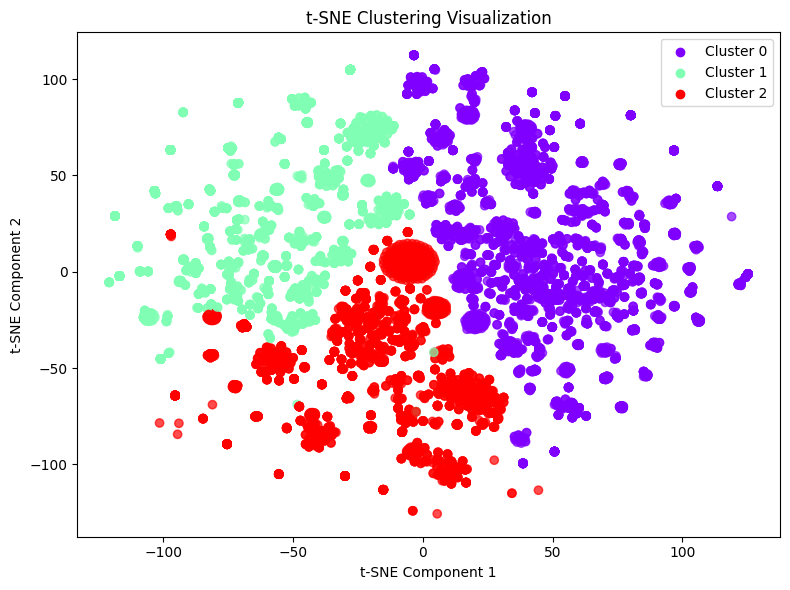

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


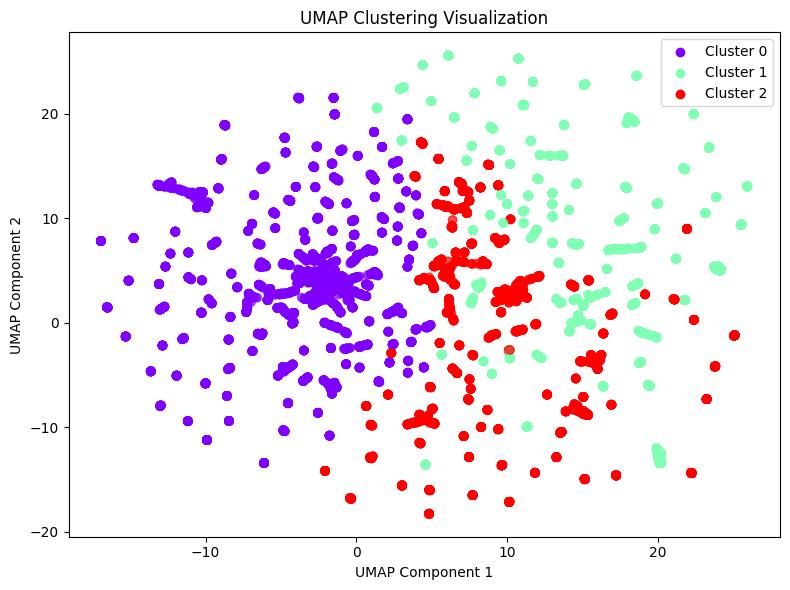


 Cluster 0:
  Top Keywords (Target): ['person_name', 'email_address', 'ip_address', 'postal_address', 'phone_number']
  Top Purpose Category: unspecified
  Top Relation: SUBSUM
  Top Source: personal information

 Cluster 1:
  Top Keywords (Target): ['personal_information', 'unspecified_data', '_pixel_tag', 'cookie_', 'information_about_you']
  Top Purpose Category: services
  Top Relation: COLLECT
  Top Source: we

 Cluster 2:
  Top Keywords (Target): ['personal_information', 'unspecified_data', 'internet_activity', 'information_about_you', 'geolocation']
  Top Purpose Category: unspecified
  Top Relation: COLLECT
  Top Source: we

=== Evaluation Metrics ===
Silhouette Scores:
  SVD:   0.8008
  t-SNE: 0.3199
  UMAP:  0.2582

Trustworthiness Scores:
  SVD:   0.9501
  t-SNE: 0.9676
  UMAP:  0.9648

Step 5: Cluster Interpretation with Parent Entities...

Cluster 0 Summary:
  Top Targets:
    - person_name (185)
    - email_address (180)
    - ip_address (139)
    - postal_address (90)
 

In [19]:

def main():
    print("Step 1: Transforming Graph YAML Files...")
    transform_graphs()
    print("\nStep 2: Performing Exploratory Data Analysis (EDA)...")
    perform_eda()
    print("\n Step 3: Clustering and Evaluation...")
    results = perform_clustering(k=3)
    eval(results)

    print("\nStep 5: Cluster Interpretation with Parent Entities...")

    # Load data and generate Parent_Entity column
    import pandas as pd
    df_with_parent = pd.read_csv("privacy_policy_data.csv")
    df_with_parent["Target_clean"] = df_with_parent["Target"].str.lower().str.strip()

    def assign_parent_entity(target):
        target = target.lower()
        if any(kw in target for kw in ["email", "name", "address", "ssn", "identifier", "username", "phone"]):
            return "personal_information"
        elif any(kw in target for kw in ["cookie", "pixel", "tag", "tracking", "browsing", "search", "analytic"]):
            return "tracking_data"
        elif any(kw in target for kw in ["geo", "location", "address"]):
            return "location_data"
        elif any(kw in target for kw in ["health", "biometric", "phi", "weight", "height"]):
            return "health_data"
        elif any(kw in target for kw in ["device", "browser", "os", "software"]):
            return "device_information"
        elif any(kw in target for kw in ["time", "date", "age", "gender", "demographic"]):
            return "demographic_data"
        elif any(kw in target for kw in ["payment", "credit", "debit", "card"]):
            return "financial_information"
        elif any(kw in target for kw in ["unspecified", "information", "non-personal", "aggregate", "data"]):
            return "ambiguous_data"
        else:
            return "other"

    df_with_parent["Parent_Entity"] = df_with_parent["Target_clean"].apply(assign_parent_entity)

    # Print enhanced cluster summaries
    print_enhanced_cluster_summaries(results["df_clean"], df_with_parent)



# Run the full pipeline
main()
